## Project2-Part2- SC, AL, NT



In [1]:
# This notebook contains general exploratory data analysis on the hate speech dataset. The data can be found here:  
# https://github.com/Vicomtech/hate-speech-dataset.git  

# The process used to collect, annotate, and model (classification) this dataset can be found in the following paper:  
# https://arxiv.org/pdf/1809.04444.pdf

In [30]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 
  'pyfunctional', 'textblob', 'seaborn', 'matplotlib'
}

installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import numpy as np
import glob
import pandas as pd
from textblob import TextBlob
from typing import List
import seaborn as sns
import matplotlib.pyplot as plt

From the original experimentation (https://arxiv.org/pdf/1809.04444.pdf) we'll use the same train and test split. 

In [31]:
# dataset git repo
if not os.path.exists("hate-speech-dataset"):
  !git clone https://github.com/Vicomtech/hate-speech-dataset.git
    
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/roohaan111/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [41]:
def get_data(paths: List[str], group: str):
  
  sets = []
  for p in paths:
    
    with open(p) as f:
      file_id = p.split('/')[-1].split('.')[0]
      sets.append((file_id, f.read(), group))
  
  return pd.DataFrame(sets, columns=["file_id", "text", "gSet"])

In [42]:
idLabels = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]

In [55]:
train_data = get_data(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
test_data = get_data(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

train_data = train_data.join(idLabels.set_index('file_id'), on='file_id')
test_data = test_data.join(idLabels.set_index('file_id'), on='file_id')

comb_data = train_data.append(test_data).reset_index(drop=True)

# print label distributions
print("Test dataset:")
print(test_data['label'].value_counts())
print("")
print("Train dataset:")
print(train_data['label'].value_counts())
print("")

print("Total datase shape:", comb_data.shape)
comb_data.tail()

Test dataset:
hate      239
noHate    239
Name: label, dtype: int64

Train dataset:
hate      957
noHate    957
Name: label, dtype: int64

Total datase shape: (2392, 4)


,file_id,text,gSet,label
2387,31732972_2,Sometimes I do watch shows about WWII on the H...,test,noHate
2388,30644911_2,It 's a pretty powerful documentary that blew ...,test,noHate
2389,30771611_2,Like the parasites they are they simply moved ...,test,hate
2390,13590005_2,Their lies are so thick and many that people d...,test,hate
2391,14672822_1,We knew that these structures were built by su...,test,noHate


We first extracted the following features to get a better understanding of the data:
1. sentence length
2. word count
3. sentiment (polarity)
4. subjectivity

In [59]:
strSer = comb_data['text'].str
txtBlob = comb_data['text'].apply(lambda s: TextBlob(s))

comb_data['sentence_len'] = strSer.len()
comb_data['word_count'] = strSer.split().apply(lambda ls: len(ls))
comb_data['polarity'] = txtBlob.apply(lambda blob: blob.sentiment.polarity)
comb_data['subjectivity'] = txtBlob.apply(lambda blob: blob.sentiment.subjectivity)

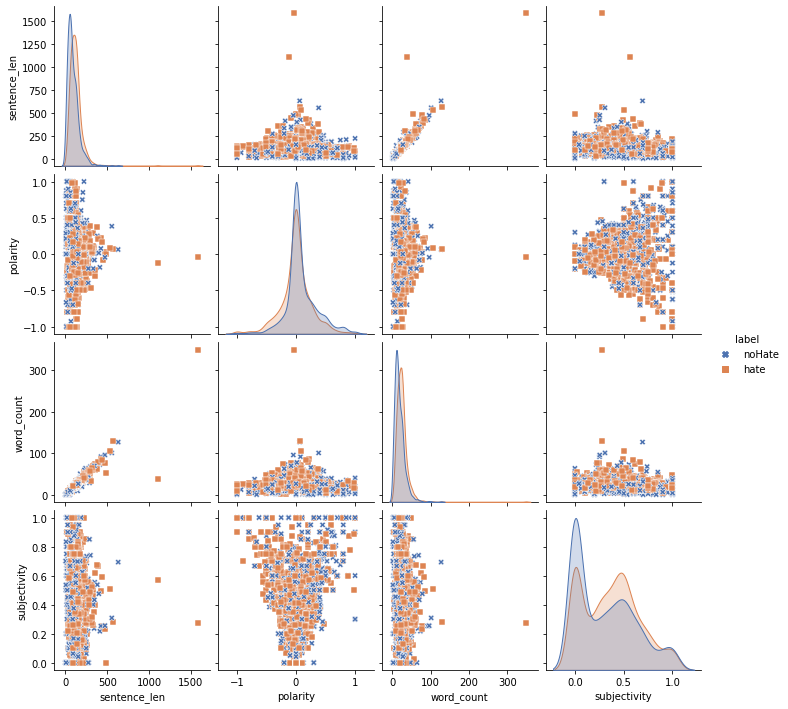

In [70]:
data_plot = comb_data[['sentence_len', 'polarity', 'word_count', 'subjectivity', 'label']]
markers = {"hate": "s", "noHate": "X"}
sns.pairplot(data_plot, hue="label", palette="deep", markers = markers)

We can see the distributions per category align well on top of each other. There is no discriminatory power in any of these metrics.

We can see the main target for these comments are blacks and jews with some minor mention of asians and muslims. This is expected given that data was gathered from a *white supremacist* forum. It might be interesting to quantify who are the primary targets of hate speech in different social media platforms. 